In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.signal import butter, filtfilt, iirnotch

Filter & Preprocessing Utilities

In [2]:
def notch_filter(data, f0=60.0, fs=500, Q=30):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, data)

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    return butter(order, [low, high], btype='band')

In [4]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

In [5]:
def moving_window_rms(signal, window_size):
    return np.sqrt(np.convolve(signal ** 2, np.ones(window_size) / window_size, mode='same'))

Per Gesture Processing

In [6]:
def process_gesture_data(path, gesture_name, fs=500, num_channels=8, window_size=200, plot=False):
    df = pd.read_csv(path)
    smoothed_signals = []
    filtered_signals = [] 

    for i in range(num_channels):
        raw = df.iloc[:, i].values
        band = bandpass_filter(raw, 8, 248, fs)
        notch = notch_filter(band, 60, fs)
        filtered_signals.append(notch)
        rms = moving_window_rms(notch, window_size)
        smoothed_signals.append(rms)

    filt_df = pd.DataFrame(smoothed_signals).T
    filt_df.columns = [f"Channel {i+1}" for i in range(num_channels)]
    filt_df['stimulus_state'] = df['stimulus_state'].values
    filt_df['gesture'] = gesture_name

    if plot:
        fig, axes = plt.subplots(num_channels, 1, figsize=(10, 12), sharex=True)
        fig.suptitle(f"Filtered EMG Data - {gesture_name}", fontsize=16)
        for i in range(num_channels):
            axes[i].plot(filt_df.iloc[:, i], linewidth=0.6)
            axes[i].set_title(f'Channel {i + 1}')
            axes[i].grid(True)
        axes[-1].set_xlabel("Time Points")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    return filt_df, pd.DataFrame(filtered_signals).T

In [7]:
def rest_baseline(df):
    rest_rows = df[df['stimulus_state'] == 'rest'].iloc[:, :8]
    return rest_rows.mean().values, rest_rows.std().values

In [8]:
def adjust_labels(df, gesture):
    mean, std = rest_baseline(df)
    high = (df.iloc[:, :8] > mean + std).all(axis=1)
    low = (df.iloc[:, :8] < mean + std).all(axis=1)
    df.loc[high, 'stimulus_state'] = 'hold'
    df.loc[low, 'stimulus_state'] = 'rest'
    df.loc[df['stimulus_state'].isin(['up', 'down']), 'stimulus_state'] = 'hold'
    df.loc[df['stimulus_state'] == 'hold', 'stimulus_state'] = gesture
    return df.iloc[:, :8].assign(stimulus_state=df['stimulus_state'])

Feature Extraction

In [9]:
def max_labels(seq):
    return Counter(seq).most_common(1)[0][0]

In [10]:
def sliding_window(df, window_size=200, stride=100):
    signal = df.iloc[:, :-1].to_numpy()
    labels = df.iloc[:, -1].to_numpy()
    X, y = [], []

    for i in range(0, len(signal) - window_size + 1, stride):
        win = signal[i:i+window_size]
        label = max_labels(labels[i:i+window_size])
        X.append(win)
        y.append(label)

    return np.array(X), np.array(y)

In [11]:
def slide_filt(df, window_size=200, stride=100):
    signal = df.iloc[:, :].to_numpy()
    X= []

    for i in range(0, len(signal) - window_size + 1, stride):
        win = signal[i:i+window_size]
        X.append(win)

    return np.array(X)

In [12]:
def compute_rms(windows):
    return np.sqrt(np.mean(np.square(windows), axis=1))

In [13]:
def mean_absolute_value(data):
    return np.mean(np.abs(data), axis=1)
def count_zero_crossings_diff(data):
    diff_signal = np.diff(np.sign(data), axis=1)
    return np.sum(np.abs(diff_signal), axis = 1) / 2

Main General Pipeline

In [14]:
def process_all_gestures(gesture_file_map, fs=500, plot_each=False):
    all_data = []
    filt_only_all =  []
    for gesture, path in gesture_file_map.items():
        print(f"Processing: {gesture} from {os.path.basename(path)}")
        df, fitlered_sig = process_gesture_data(path, gesture, fs=fs, plot=plot_each)
        df = adjust_labels(df, gesture)
        all_data.append(df)
        filt_only_all.append(fitlered_sig)

    combined = pd.concat(all_data, ignore_index=True)
    combined_filtered = pd.concat(filt_only_all, ignore_index=True)

    win_data, win_labels = sliding_window(combined, window_size=200, stride=100)
    fitlered_win = slide_filt(combined_filtered, window_size=200, stride=100)

    X_rms = compute_rms(win_data)
    X_mav = mean_absolute_value(win_data)
    X_zc = count_zero_crossings_diff(fitlered_win)
    return X_rms, X_mav, X_zc, win_labels, combined

File Input

In [71]:
gesture_files = {
    "wflex" : "E:/Mindrove_venv/Smart_select_Wflex_data_2025_06_12_Dheemant_MAV_ZC_PCA_V1_0_unfilt.csv",
    "wexten" : "E:/Mindrove_venv/Smart_select_WExten_data_2025_06_12_Dheemant_MAV_ZC_PCA_V1_0_unfilt.csv",
    # "wradial" : "E:/Mindrove_venv/Data_Gestures_RTMC/Smart_select_WRadial_data_2025_06_02_Dheemant_Actual_0_unfilt.csv",
    # "wulnar" : "E:/Mindrove_venv/Data_Gestures_RTMC/Smart_select_WUlnar_data_2025_06_02_Dheemant_Actual_0_unfilt.csv",
    # "FThumb" : "E:/Mindrove_venv\Data_Gestures_RTMC/Smart_select_FThumb_data_2025_06_02_Dheemant_Actual_0_unfilt.csv",
    "FIndex" : "E:/Mindrove_venv/Smart_select_FIndex_data_2025_06_12_Dheemant_MAV_ZC_PCA_V1_0_unfilt.csv",
    # "FMiddle" : "E:\Mindrove_venv\Smart_select_FMiddle_data_2025_06_02_Dheemant_Actual_0_unfilt.csv",
    # "FRing" : "E:\Mindrove_venv\Smart_select_FRing_data_2025_06_02_Dheemant_Actual_0_unfilt.csv",
    # "FPinky" : "E:\Mindrove_venv\Smart_select_FPinky_data_2025_06_02_Dheemant_Actual_0_unfilt.csv",
    # "FThumb_Iso" : "E:\Mindrove_venv\Smart_select_FThumb_Iso_data_2025_06_03_Dheemant_Iso_0_unfilt.csv",
    # "FIndex_Iso" : "E:\Mindrove_venv\Smart_select_FIndex_Iso_data_2025_06_03_Dheemant_Iso_0_unfilt.csv",
    # "FMiddle_Iso" : "E:\Mindrove_venv\Smart_select_FMiddle_Iso_data_2025_06_03_Dheemant_Iso_0_unfilt.csv",
    # "FRing_Iso" : "E:\Mindrove_venv\Smart_select_FRing_Iso_data_2025_06_03_Dheemant_Iso_0_unfilt.csv",
    
}

In [72]:
X_rms, X_mav, X_zc, Windowedlabels, df_combined = process_all_gestures(gesture_files, plot_each=False)

Processing: wflex from Smart_select_Wflex_data_2025_06_12_Dheemant_MAV_ZC_PCA_V1_0_unfilt.csv
Processing: wexten from Smart_select_WExten_data_2025_06_12_Dheemant_MAV_ZC_PCA_V1_0_unfilt.csv
Processing: FIndex from Smart_select_FIndex_data_2025_06_12_Dheemant_MAV_ZC_PCA_V1_0_unfilt.csv


In [73]:
print(f"Shape of RMS features: {X_rms.shape}")
print(f"Shape of MAV features: {X_mav.shape}")
print(f"Shape of ZC features: {X_zc.shape}")

Shape of RMS features: (2488, 8)
Shape of MAV features: (2488, 8)
Shape of ZC features: (2488, 8)


In [74]:
X_features = np.concatenate([X_rms, X_mav, X_zc], axis=1)

In [75]:
print(f"combined feature matrix: {X_features.shape}")

combined feature matrix: (2488, 24)


In [76]:
X_features_df = pd.DataFrame(X_features)

In [77]:
np.unique(Windowedlabels)

array(['FIndex', 'rest', 'wexten', 'wflex'], dtype='<U6')

PCA

In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [83]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

In [84]:
# Extract eigenvalues (λ = variance explained by each PC)
lambdas = pca.explained_variance_

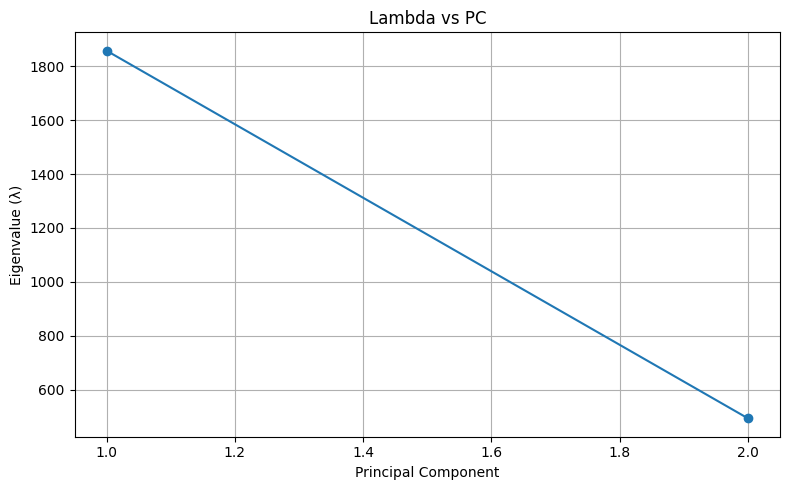

In [85]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(lambdas) + 1), lambdas, marker='o')
plt.title("Lambda vs PC")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue (λ)")
plt.grid(True)
plt.tight_layout()
plt.show()

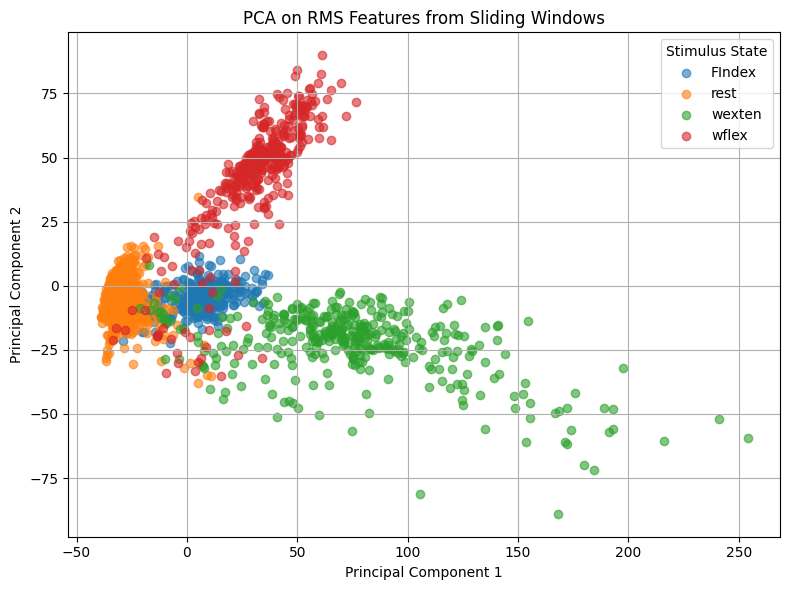

In [86]:
# 4. Visualization
plt.figure(figsize=(8, 6))
for cls in np.unique(Windowedlabels):
    idx = Windowedlabels == cls
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=str(cls), alpha=0.6)

plt.title("PCA on RMS Features from Sliding Windows")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Stimulus State")
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
# Convert string labels to integers
le = LabelEncoder()
numeric_labels = le.fit_transform(Windowedlabels) 

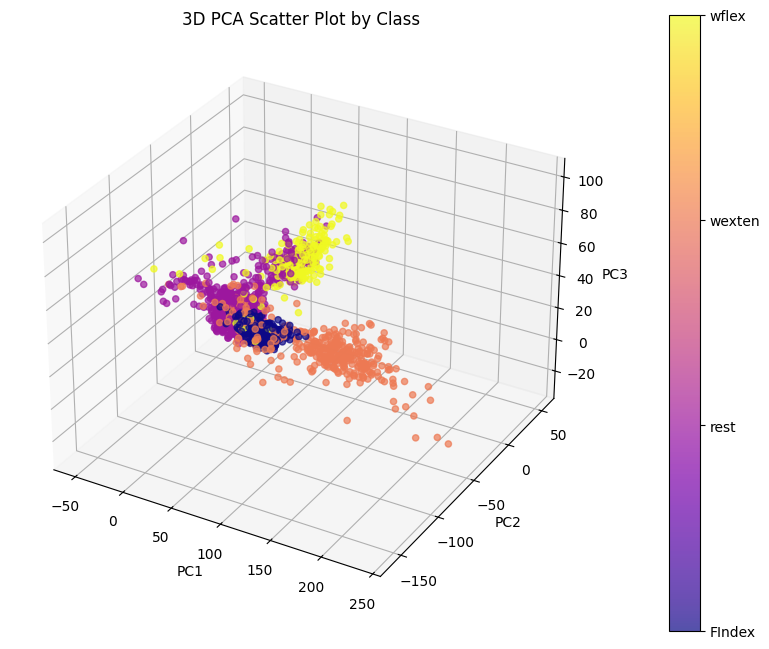

In [33]:
# Plot 3D PCA
fig = plt.figure(figsize=(10, 8))
axis = fig.add_subplot(111, projection='3d')

scatter = axis.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                       c=numeric_labels, cmap='plasma', alpha=0.7)

# Add colorbar with correct class names
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_ticks(np.unique(numeric_labels))
cbar.set_ticklabels(le.classes_)

axis.set_xlabel("PC1")
axis.set_ylabel("PC2")
axis.set_zlabel("PC3")
plt.title("3D PCA Scatter Plot by Class")
plt.show()


VISUALIZATION

In [88]:
label_colors = {
    'rest': 'yellow',
    'wflex': 'red',
    'wexten': 'blue',
    # 'wradial': 'green',
    # 'wulnar': 'orange',
    # 'FThumb': 'magenta',
    'FIndex': 'cyan',
    # 'FMiddle': 'purple',
    # 'FRing': 'brown',
    # 'FPinky': 'pink'
    # "FThumb_Iso" : "green",
    # "FIndex_Iso" : "red",
    # "FMiddle_Iso" : "blue",
    # "FRing_Iso" : "purple"
    
}

In [89]:
emg_channel = df_combined.iloc[:, 0].to_numpy()
labels = df_combined['stimulus_state'].to_numpy()
time = np.arange(len(emg_channel))

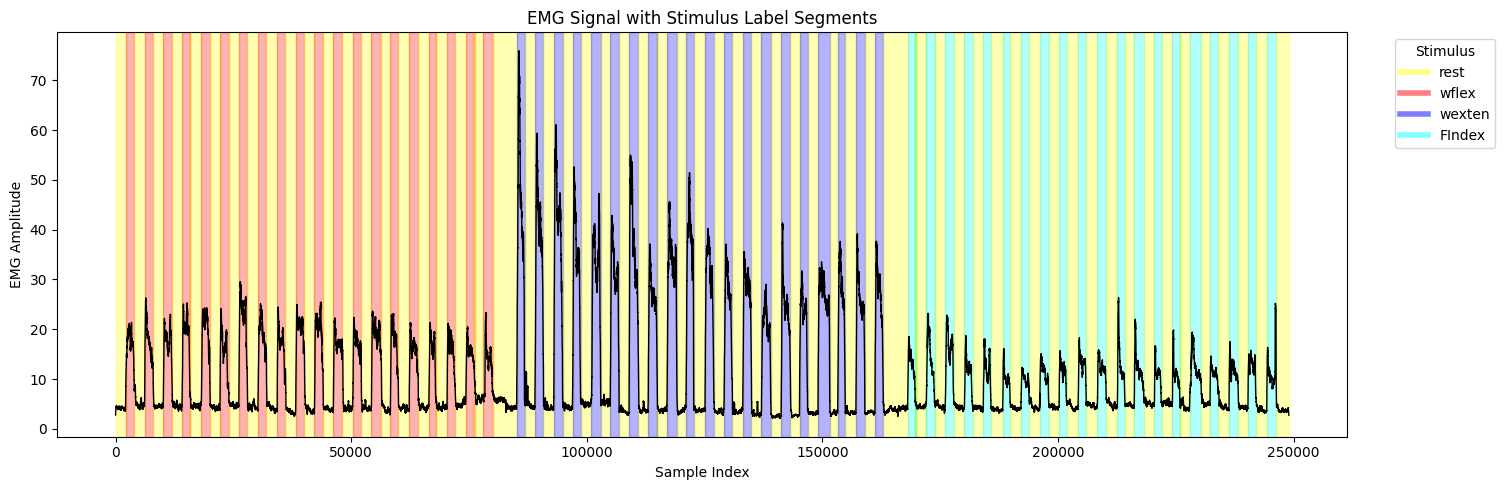

In [115]:
plt.figure(figsize=(15, 5))
plt.plot(time, emg_channel, label='Channel 1', color='black', linewidth=1)

# Segment shading based on labels
prev_label = labels[0]
start_idx = 0

for i in range(1, len(labels)):
    if labels[i] != prev_label:
        color = label_colors.get(prev_label, 'gray')  # fallback to gray if label not found
        plt.axvspan(start_idx, i, color=color, alpha=0.3, label=prev_label)
        start_idx = i
        prev_label = labels[i]

# Final segment
color = label_colors.get(prev_label, 'gray')
plt.axvspan(start_idx, len(labels), color=color, alpha=0.3, label=prev_label)

plt.title("EMG Signal with Stimulus Label Segments")
plt.xlabel("Sample Index")
plt.ylabel("EMG Amplitude")

# Only show unique labels in legend
handles = [
    plt.Line2D([0], [0], color=label_colors[label], lw=4, alpha=0.5)
    for label in label_colors
]
plt.legend(handles, label_colors.keys(), title='Stimulus', bbox_to_anchor=(1.12, 1))

plt.tight_layout()
plt.show()


Pairplot

In [116]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

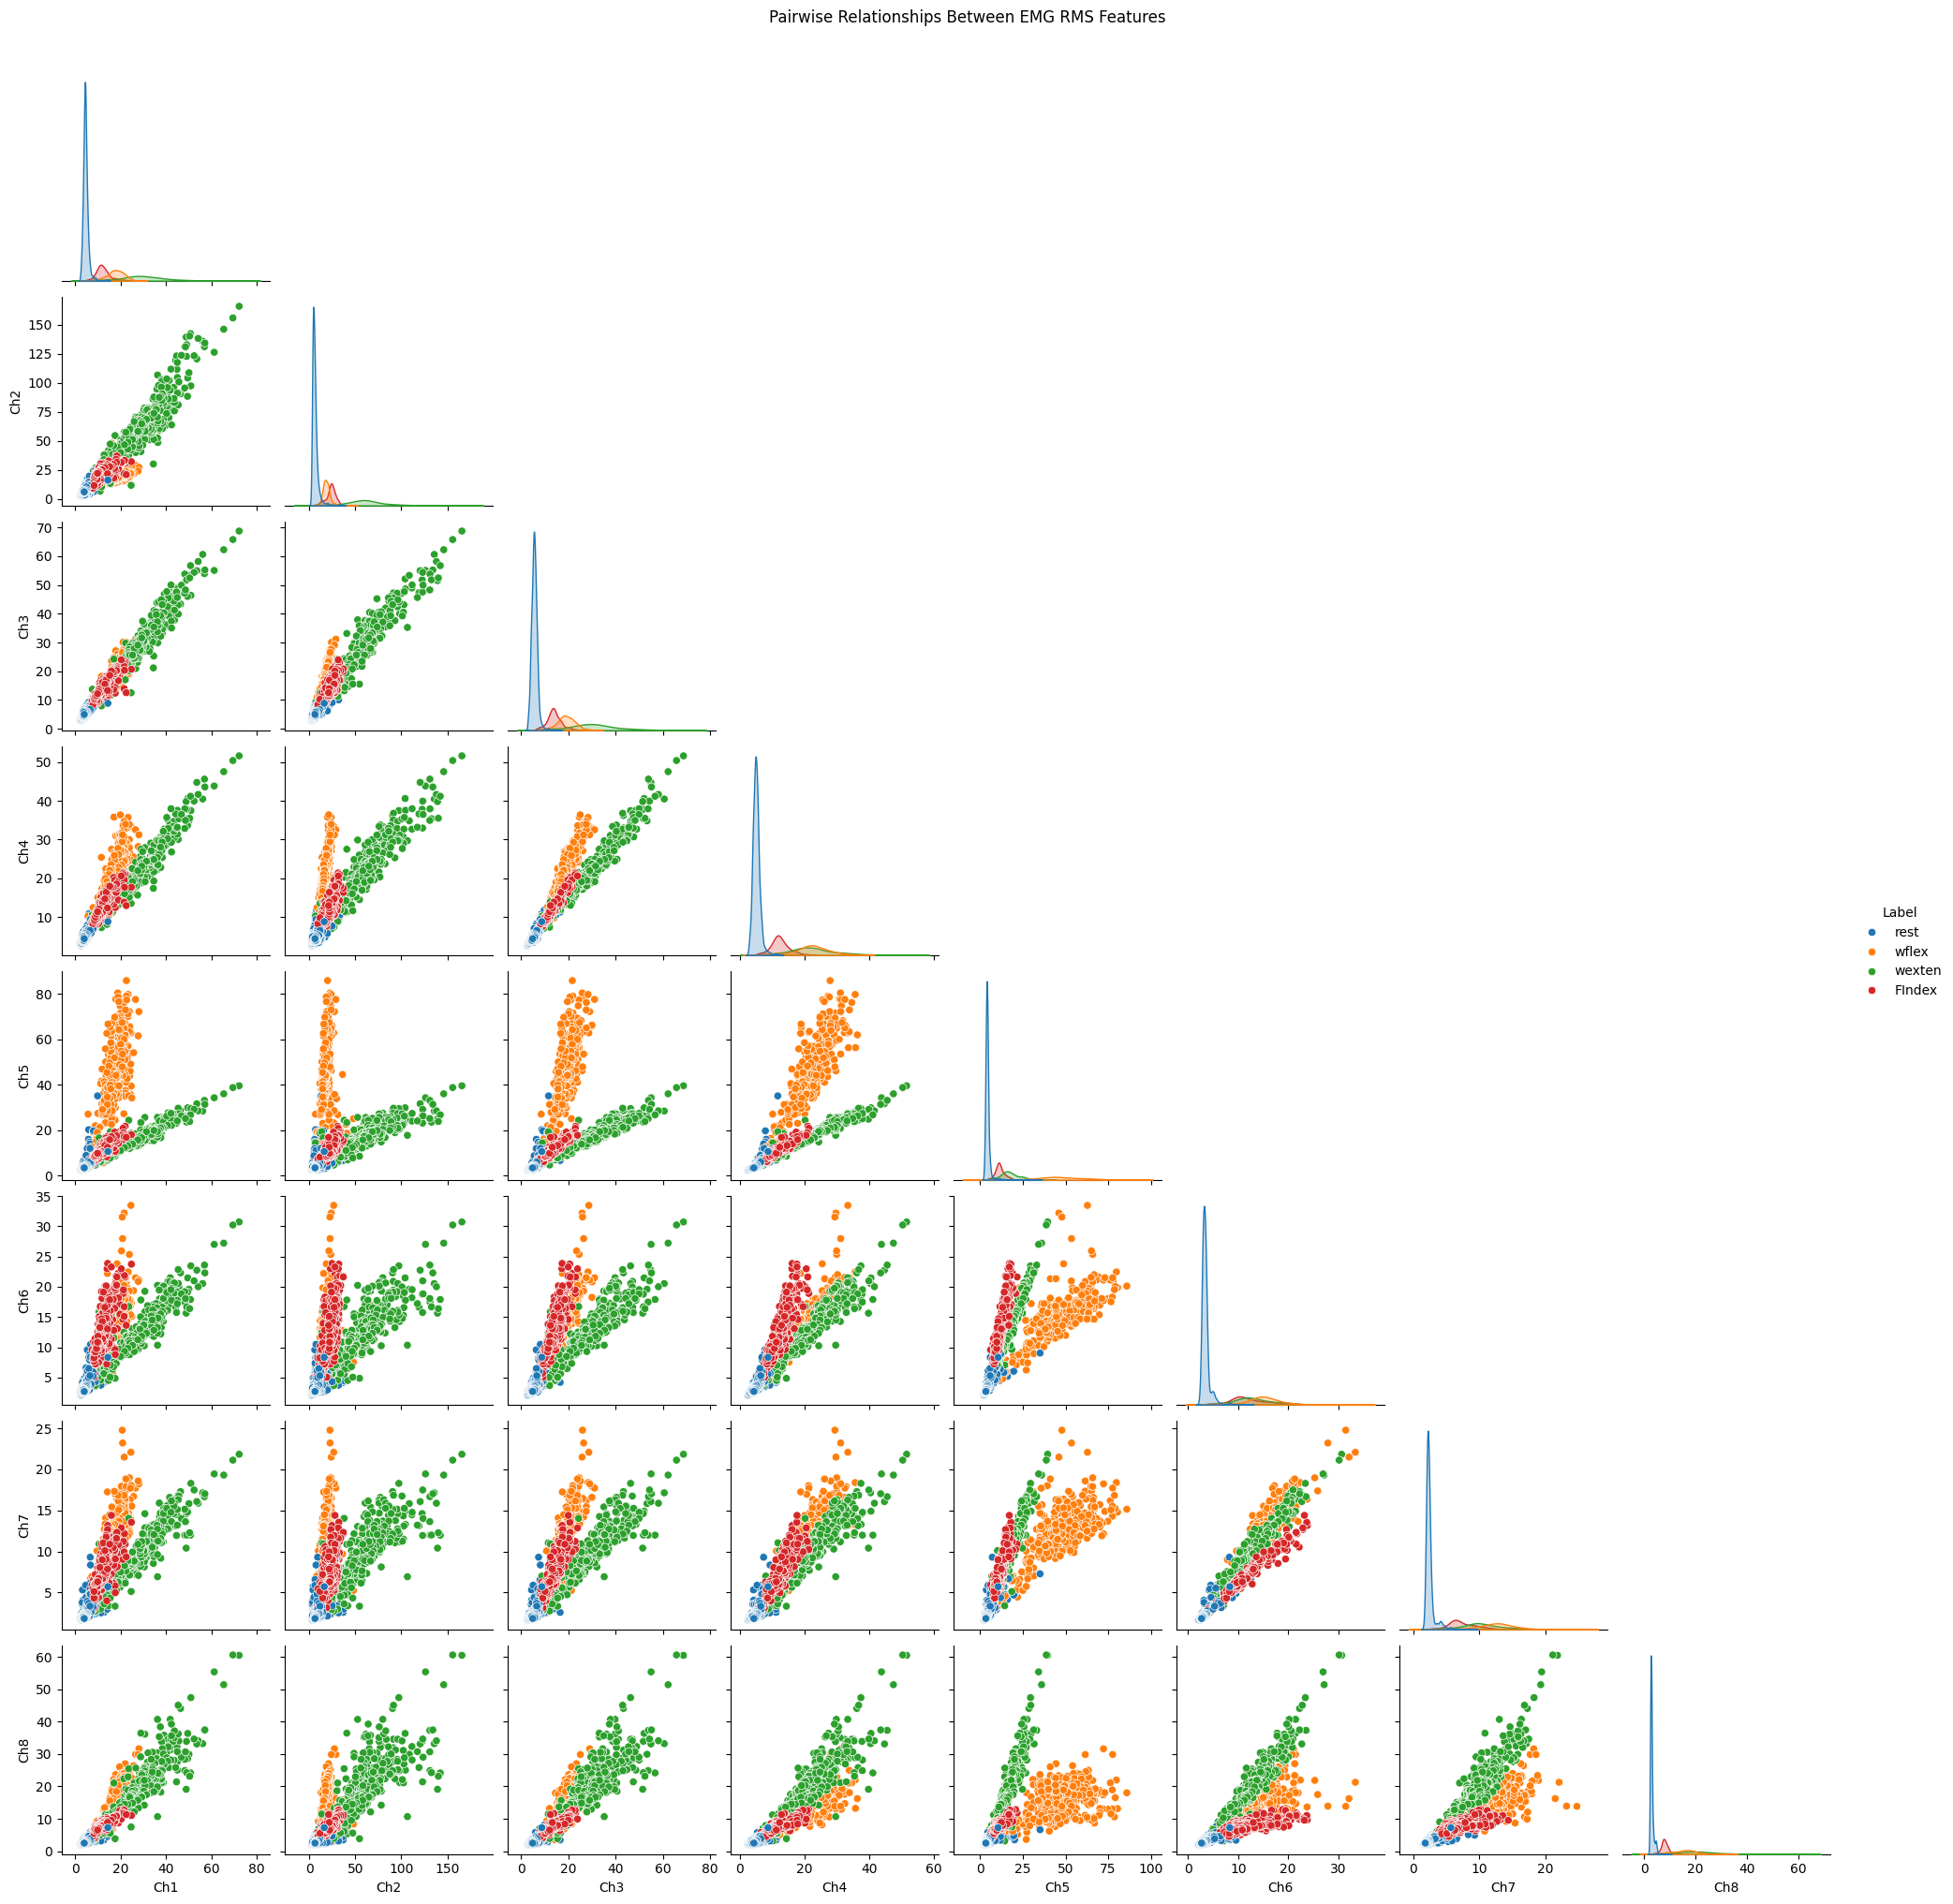

In [117]:
df_rms = pd.DataFrame(X_rms, columns=[f'Ch{i+1}' for i in range(X_rms.shape[1])])
df_rms['Label'] = Windowedlabels  # Add label column

# Pairplot with hue
sns.pairplot(df_rms, hue='Label', palette='tab10', corner=True)
plt.suptitle("Pairwise Relationships Between EMG RMS Features", y=1.02)
plt.show()

LDA APPLICATION

In [118]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [159]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_pca, Windowedlabels, test_size=0.2, random_state=42)

In [160]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_, y_train_)

LinearDiscriminantAnalysis()

In [161]:
X_train_lda = lda.transform(X_train_)
X_test_lda = lda.transform(X_test_)

In [162]:
unique_classes = np.unique(y_train_)
colors = [label_colors[label] for label in unique_classes]

Plotting 2D scatter plot using the first two Linear Discriminants.


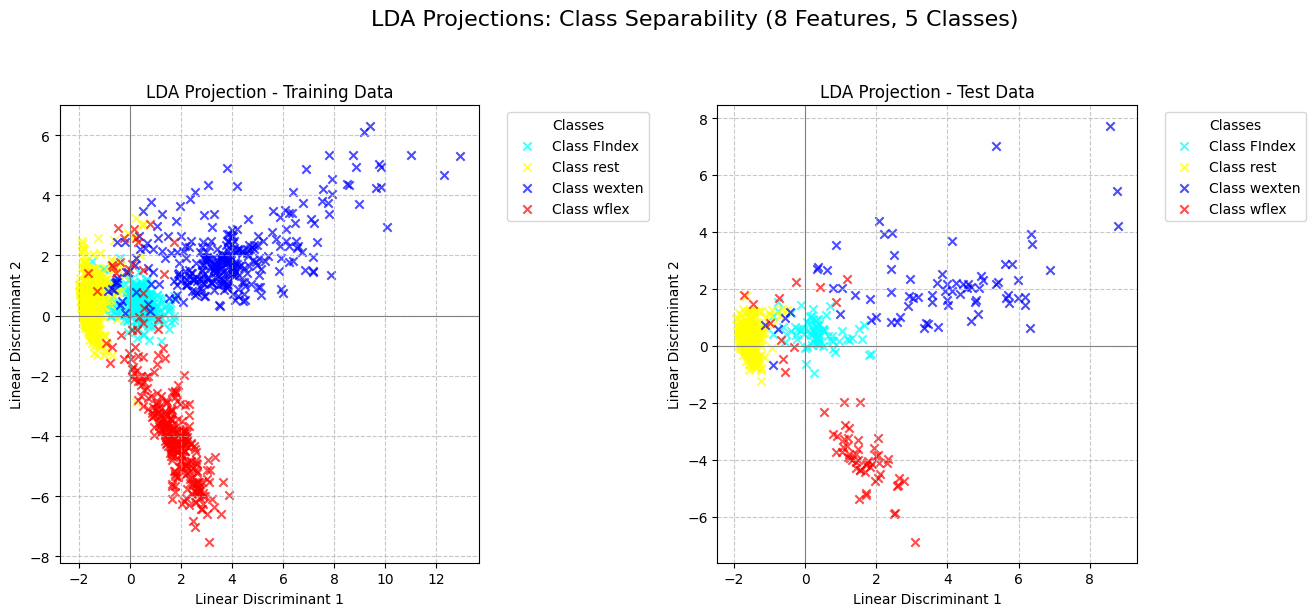

In [163]:
print("Plotting 2D scatter plot using the first two Linear Discriminants.")

plt.figure(figsize=(14, 6))

# Plot Training Data
plt.subplot(1, 2, 1)
for i, class_label in enumerate(unique_classes):
    plt.scatter(X_train_lda[y_train_ == class_label, 0],
                X_train_lda[y_train_ == class_label, 1],
                alpha=0.7, color=colors[i], label=f'Class {class_label}', marker='x')
plt.title('LDA Projection - Training Data')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.8) # Add axes at zero for reference
plt.axvline(0, color='gray', linewidth=0.8)

# Plot Test Data
plt.subplot(1, 2, 2)
for i, class_label in enumerate(unique_classes):
    plt.scatter(X_test_lda[y_test_ == class_label, 0],
                X_test_lda[y_test_ == class_label, 1],
                alpha=0.7, color=colors[i], label=f'Class {class_label}', marker='x') # Use 'x' marker for test data
plt.title('LDA Projection - Test Data')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)

plt.suptitle('LDA Projections: Class Separability (8 Features, 5 Classes)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.95, 0.98]) # Adjust layout to make space for suptitle and side legend
plt.show()

In [164]:
y_pred_ = lda.predict(X_test_)
accuracy = accuracy_score(y_test_, y_pred_)
print(f"Accuracy (LDA): {accuracy*100}")

Accuracy (LDA): 89.95983935742971


<Figure size 600x600 with 0 Axes>

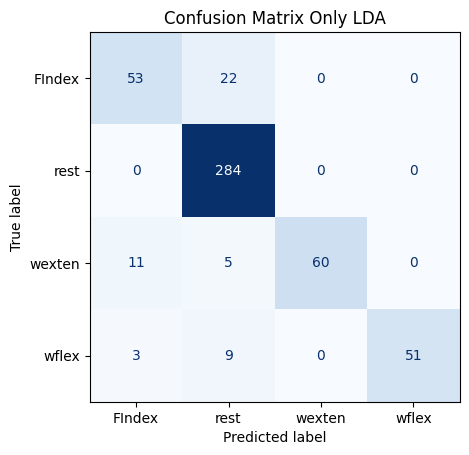

In [165]:
cm = confusion_matrix(y_test_, y_pred_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_))

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', colorbar=False)
plt.title("Confusion Matrix Only LDA")
plt.grid(False)
plt.show()

In [166]:
print(classification_report(y_test_,y_pred_))

              precision    recall  f1-score   support

      FIndex       0.79      0.71      0.75        75
        rest       0.89      1.00      0.94       284
      wexten       1.00      0.79      0.88        76
       wflex       1.00      0.81      0.89        63

    accuracy                           0.90       498
   macro avg       0.92      0.83      0.87       498
weighted avg       0.90      0.90      0.90       498



Other Classifiers

In [167]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [168]:
classifiers = {
    'LDA' : LinearDiscriminantAnalysis(),
    'SVM (RBF Kernel)': SVC(kernel='rbf', C=1.0, gamma='scale'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'k-NN': KNeighborsClassifier(n_neighbors=4),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
}

In [169]:
results = []

In [170]:
unique_classes = np.unique(y_train_)
colors = [label_colors[label] for label in unique_classes]

              precision    recall  f1-score   support

      FIndex       0.79      0.71      0.75        75
        rest       0.89      1.00      0.94       284
      wexten       1.00      0.79      0.88        76
       wflex       1.00      0.81      0.89        63

    accuracy                           0.90       498
   macro avg       0.92      0.83      0.87       498
weighted avg       0.90      0.90      0.90       498



<Figure size 600x600 with 0 Axes>

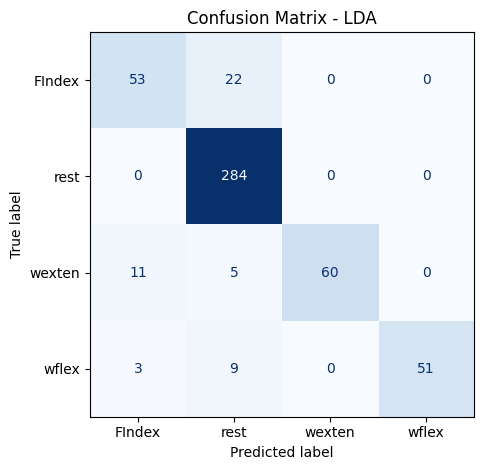

              precision    recall  f1-score   support

      FIndex       0.90      0.95      0.92        75
        rest       0.96      1.00      0.98       284
      wexten       0.96      0.92      0.94        76
       wflex       1.00      0.81      0.89        63

    accuracy                           0.95       498
   macro avg       0.95      0.92      0.93       498
weighted avg       0.96      0.95      0.95       498



<Figure size 600x600 with 0 Axes>

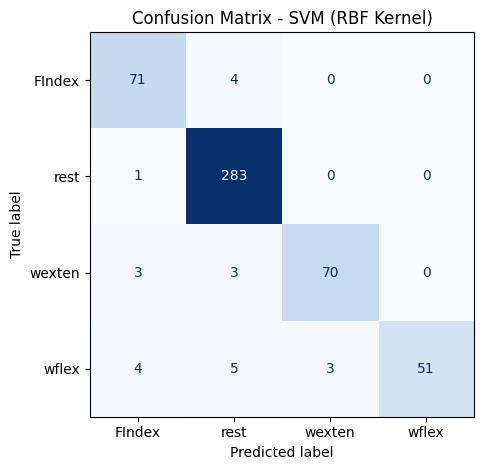

              precision    recall  f1-score   support

      FIndex       0.93      0.87      0.90        75
        rest       0.97      0.99      0.98       284
      wexten       0.86      0.93      0.89        76
       wflex       0.98      0.86      0.92        63

    accuracy                           0.95       498
   macro avg       0.93      0.91      0.92       498
weighted avg       0.95      0.95      0.95       498



<Figure size 600x600 with 0 Axes>

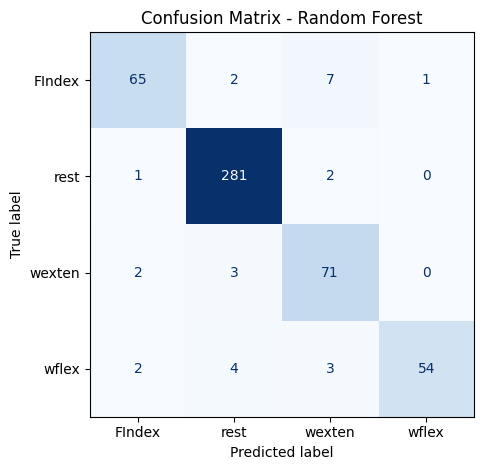

              precision    recall  f1-score   support

      FIndex       0.90      0.92      0.91        75
        rest       0.97      0.98      0.98       284
      wexten       0.91      0.92      0.92        76
       wflex       0.95      0.84      0.89        63

    accuracy                           0.95       498
   macro avg       0.93      0.92      0.92       498
weighted avg       0.95      0.95      0.95       498



<Figure size 600x600 with 0 Axes>

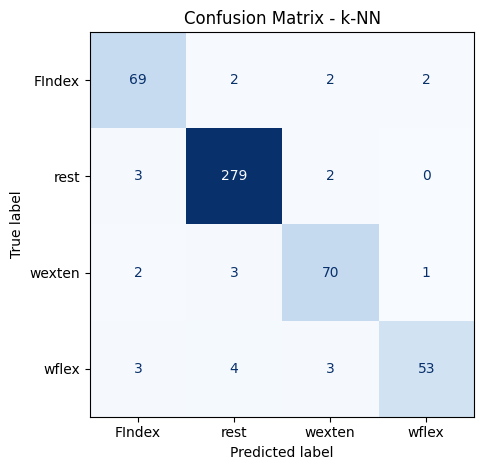

              precision    recall  f1-score   support

      FIndex       0.89      0.91      0.90        75
        rest       0.96      0.99      0.98       284
      wexten       0.93      0.92      0.93        76
       wflex       0.96      0.84      0.90        63

    accuracy                           0.95       498
   macro avg       0.94      0.91      0.93       498
weighted avg       0.95      0.95      0.95       498



<Figure size 600x600 with 0 Axes>

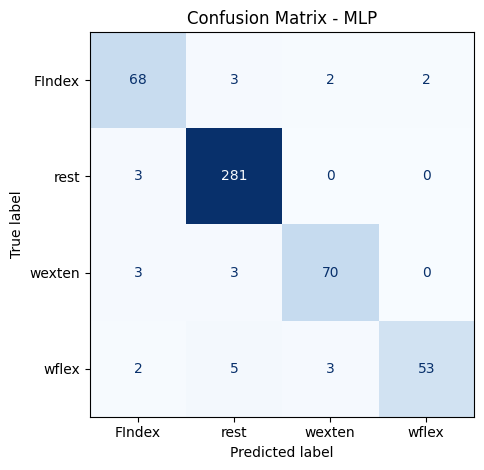

In [174]:
for name, clf in classifiers.items():
    clf.fit(X_train_, y_train_)
    y_pred_ = clf.predict(X_test_)
    acc = accuracy_score(y_test_, y_pred_)
    cm = confusion_matrix(y_test_, y_pred_)

    results.append({
        'name': name,
        'accuracy': acc,
        'confusion_matrix': cm
    })
    print(classification_report(y_test_,y_pred_))
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results).drop(columns='confusion_matrix')

In [172]:
print(results_df)

               name  accuracy
0               LDA  0.899598
1  SVM (RBF Kernel)  0.953815
2     Random Forest  0.943775
3              k-NN  0.945783
4               MLP  0.947791


In [173]:
print(classification_report(y_test_,y_pred_))

              precision    recall  f1-score   support

      FIndex       0.89      0.91      0.90        75
        rest       0.96      0.99      0.98       284
      wexten       0.93      0.92      0.93        76
       wflex       0.96      0.84      0.90        63

    accuracy                           0.95       498
   macro avg       0.94      0.91      0.93       498
weighted avg       0.95      0.95      0.95       498



Save Models

In [153]:
import joblib
import datetime

In [154]:
trained_classifiers = {
    # 'SVM_RBF': classifiers['SVM (RBF Kernel)'],
    # 'RandomForest': classifiers['Random Forest'],
    # 'kNN': classifiers['k-NN'],
    'MLP': classifiers['MLP']
}

In [155]:
today_str = datetime.date.today().strftime("%Y_%m_%d")
participant = "data_2025_06_12_Dheemant_MAV_ZC_withoutPCA_V1_0"
actions =   "FLEX_EXTEN_INDEX" #"THUMB_INDEX_MIDDLE_RING_ISOMETRIC" # "FLEX_EXTEN_RADIAL_ULNAR"

In [156]:
for result in results:
    clf_name = result['name'].replace(" ", "").replace("(", "").replace(")", "").replace("-", "")
    accuracy_pct = int(result['accuracy'] * 100)
    model = classifiers[result['name']]
    
    filename = f"{clf_name}_{accuracy_pct}_{today_str}_{participant}_{actions}_0.pkl"
    joblib.dump(model, filename)
    print(f"Saved: {filename}")

Saved: LDA_95_2025_06_12_data_2025_06_12_Dheemant_MAV_ZC_withoutPCA_V1_0_FLEX_EXTEN_INDEX_0.pkl
Saved: SVMRBFKernel_95_2025_06_12_data_2025_06_12_Dheemant_MAV_ZC_withoutPCA_V1_0_FLEX_EXTEN_INDEX_0.pkl
Saved: RandomForest_96_2025_06_12_data_2025_06_12_Dheemant_MAV_ZC_withoutPCA_V1_0_FLEX_EXTEN_INDEX_0.pkl
Saved: kNN_95_2025_06_12_data_2025_06_12_Dheemant_MAV_ZC_withoutPCA_V1_0_FLEX_EXTEN_INDEX_0.pkl
Saved: MLP_96_2025_06_12_data_2025_06_12_Dheemant_MAV_ZC_withoutPCA_V1_0_FLEX_EXTEN_INDEX_0.pkl


In [157]:
pca_save_path = f"PCA_{actions}_{participant}.pkl"
joblib.dump(pca, pca_save_path)
print(f"PCA model saved to: {pca_save_path}")

PCA model saved to: PCA_FLEX_EXTEN_INDEX_data_2025_06_12_Dheemant_MAV_ZC_withoutPCA_V1_0.pkl
